In [1]:
from random import random
from math import sqrt, log,  exp, erf
from numba import njit, prange
from numpy.random import normal
import numpy

import matplotlib.pyplot as plt

import time

def time_call(callback):
    start_time = time.perf_counter()
    callback()
    return (time.perf_counter() - start_time)

In [22]:
@njit(fastmath=True)
def box_muller_rand():
    while True:
        x = random() * 2.0 - 1
        y = random() * 2.0 - 1
        d = x * x + y * y 
        if d < 1:
            return x * sqrt(-2 * log(d) / d)

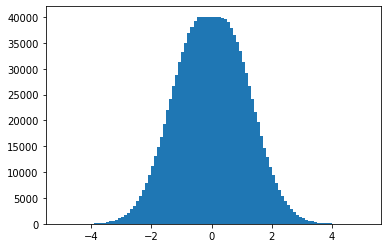

In [23]:
bins = { }
for i in range(1000000):
    num = round(box_muller_rand(), 1)
    bins[num] = bins.get(num, 0) + 1

plt.bar(bins.keys(), bins.values())
plt.show()

In [32]:
@njit(fastmath=True)
def create_path(initial, time, steps, volatility, risk_free):
    dt = time / steps
    sdt = sqrt(dt)

    path = []
    current = initial
    for i in range(steps):
        path.append(current)
        current = current * exp((risk_free - 0.5 * volatility * volatility) * dt + volatility * sdt * box_muller_rand())
    
    return path

def create_path_numpy(initial, time, steps, volatility, risk_free):
    dt = time / steps
    sdt = sqrt(dt)
    drift = exp((risk_free - 0.5 * volatility * volatility) * dt)

    randoms = numpy.exp(normal(size=steps)*volatility*sdt) * drift
    randoms[0] = 1
    return numpy.cumprod(randoms) * initial


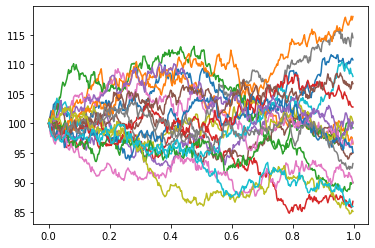

In [34]:
paths = []
x = [x / 365 for x in range(365)]
for i in range(20):
    paths.append(create_path_numpy(100, 1, 365, 0.1, 0.01))
    plt.plot(x, paths[-1])

In [49]:
def price_option(strike, spot, time, volatility, risk_free, call_or_put='c', knockin=None, knockout=None, simulations=2000, steps_per_unit = 365):
    if knockin and knockout:
        raise Exception("Unable to cope with 2 barriers!")

    cp = 1 if call_or_put == 'c' else -1

    premiums = []
    for i in range(simulations):
        path = create_path_numpy(spot, time, time * steps_per_unit, volatility, risk_free)
        if knockin and knockin > spot and max(path) < knockin: # Up and In
            premiums.append(0)
        elif knockin and knockin < spot and min(path) > knockin: # Down and In
            premiums.append(0)
        elif knockout and knockout < spot and min(path) < knockin: # Down and Out
            premiums.append(0)
        elif knockout and knockout > spot and max(path) > knockout: # Up and Out
            premiums.append(0)
        else:
            premiums.append(max(0, cp * (path[-1] - strike)))

    return sum(premiums) / simulations * exp(-time * risk_free)

In [50]:
spot=100
strike=105
vol=0.2
risk_free=0.05

time_call(lambda: price_option(strike, spot, 1, vol, risk_free, simulations=50000))

1.618802199998754

In [56]:
@njit(fastmath=True)
def path_final_min_max(initial, steps, sdt, volatility, drift):
    current = initial
    minimum = current
    maximum = current
    for i in range(steps - 1):
        current = current * drift * exp(sdt * volatility * box_muller_rand())
        if minimum > current:
            minimum = current
        if maximum < current:
            maximum = current

    return current, minimum, maximum

@njit(fastmath=True)
def payoff(value, minimum, maximum, cp, knockin, knockout, strike):
    if knockin and knockin > spot and maximum < knockin: # Up and In
        return 0
    elif knockin and knockin < spot and minimum > knockin: # Down and In
        return 0
    elif knockout and knockout < spot and minimum < knockin: # Down and Out
        return 0
    elif knockout and knockout > spot and maximum > knockout: # Up and Out
        return 0
    return max(0, cp * (value - strike))

@njit(parallel=True, fastmath=True)
def price_option_2(strike, spot, time, volatility, risk_free, call_or_put='c', knockin=0, knockout=0, simulations=2000, steps_per_unit = 365):
    if knockin and knockout:
        raise Exception("Unable to cope with 2 barriers!")

    cp = 1 if call_or_put == 'c' else -1
    dt = 1 / steps_per_unit
    steps = int(time * steps_per_unit)
    sdt = sqrt(dt)
    drift = exp((risk_free - 0.5 * volatility * volatility) * dt)

    total_premium = 0
    for i in prange(simulations):
        value, minimum, maximum = path_final_min_max(spot, steps, sdt, volatility, drift)
        total_premium += payoff(value, minimum, maximum, cp, knockin, knockout, strike)

    return total_premium / simulations * exp(-time * risk_free)

In [91]:
time_call(lambda: print(price_option_2(strike, spot, 1, vol, risk_free, simulations=50000)))

7.992317832282393


0.21846229999209754

In [89]:
def path_final_min_max_numpy(initial, steps, sdt, volatility, riskfree):
    randoms = numpy.exp(normal(size=steps)*volatility*sdt) * drift
    randoms[0] = 1
    factors = numpy.cumprod(randoms) * initial
    return factors[-1], numpy.min(factors), numpy.max(factors)

def price_option_2_numpy(strike, spot, time, volatility, risk_free, call_or_put='c', knockin=0, knockout=0, simulations=2000, steps_per_unit = 365):
    if knockin and knockout:
        raise Exception("Unable to cope with 2 barriers!")

    cp = 1 if call_or_put == 'c' else -1
    dt = 1 / steps_per_unit
    steps = int(time * steps_per_unit)
    sdt = sqrt(dt)
    drift = exp((risk_free - 0.5 * volatility * volatility) * dt)

    total_premium = 0
    for i in range(simulations):
        value, minimum, maximum = path_final_min_max_numpy(spot, steps, sdt, volatility, drift)
        total_premium += payoff(value, minimum, maximum, cp, knockin, knockout, strike)

    return total_premium / simulations * exp(-time * risk_free)


In [92]:
time_call(lambda: print(price_option_2_numpy(strike, spot, 1, vol, risk_free, simulations=50000)))

8.04471013039889


1.659968599997228

In [75]:
sim_tests = [100,200,500,1000,2000,5000,10000,20000,50000]
sim_out = {}
for sim in sim_tests:
    results = []
    for i in range(20):
        results.append(price_option(strike, spot, 1, vol, risk_free, simulations=sim))
    sim_out[sim] = {
        'min': min(results),
        'max': max(results),
        'mean': sum(results) / 20
    }
sim_out

{20000: {'min': 7.830023543668947,
  'max': 8.198467687906678,
  'mean': 8.011391595546261},
 50000: {'min': 7.88287244842448,
  'max': 8.133164154341774,
  'mean': 7.991736385861546}}

In [2]:
@njit(fastmath=True)
def cdf(x):
    return (1.0 + erf(x / sqrt(2.0))) / 2.0

@njit(fastmath=True)
def bs_d1(strike, spot, time, volatility, risk_free, dividend):
    return (log(spot/strike) + (risk_free - dividend + (volatility * volatility / 2)) * time) / (volatility * sqrt(time))

@njit(fastmath=True)
def bs_d2(strike, spot, time, volatility, risk_free, dividend):
    return bs_d1(strike, spot, time, volatility, risk_free, dividend) - volatility * sqrt(time)

@njit(fastmath=True)
def bs_call(strike, spot, time, volatility, risk_free, dividend):
    d1 = bs_d1(strike, spot, time, volatility, risk_free, dividend)
    d2 = d1 - volatility * sqrt(time)
    return spot * exp(-dividend * time) * cdf(d1) - strike * exp(-risk_free * time) * cdf(d2)

@njit(fastmath=True)
def bs_put(strike, spot, time, volatility, risk_free, dividend):
    d1 = bs_d1(strike, spot, time, volatility, risk_free, dividend)
    d2 = d1 - volatility * sqrt(time)
    return -spot * exp(-dividend * time) * cdf(-d1) + strike * exp(-risk_free * time) * cdf(-d2)

@njit(fastmath=True)
def bs_price_option(strike, spot, time, volatility, risk_free, dividend=0, call_or_put='c'):
    if call_or_put == 'c':
        return bs_call(strike, spot, time, volatility, risk_free, dividend)
    if call_or_put == 'p':
        return bs_put(strike, spot, time, volatility, risk_free, dividend)
    return -1


In [78]:
bs_call(105, 100, 1, 0.2, 0.05, 0), bs_put(105, 100, 1, 0.2, 0.05, 0)

(8.021352235143175, 7.9004418077181455)

In [41]:
def rr_mu(risk_free, dividend, volatility):
    return (risk_free - dividend) / (volatility ** 2) - 0.5

def rr_x1(strike, spot, time, volatility, risk_free, dividend):
    return log(spot / strike) / (volatility * sqrt(time)) + (1 + rr_mu(risk_free, dividend, volatility)) * volatility * sqrt(time)

def rr_x2(barrier, spot, time, volatility, risk_free, dividend):
    return log(spot / barrier) / (volatility * sqrt(time)) + (1 + rr_mu(risk_free, dividend, volatility)) * volatility * sqrt(time)

def rr_y1(strike, barrier, spot, time, volatility, risk_free, dividend):
    return log(barrier * barrier / (spot * strike)) / (volatility * sqrt(time)) + (1 + rr_mu(risk_free, dividend, volatility)) * volatility * sqrt(time)

def rr_y2(barrier, spot, time, volatility, risk_free, dividend):
    return log(barrier / spot) / (volatility * sqrt(time)) + (1 + rr_mu(risk_free, dividend, volatility)) * volatility * sqrt(time)

def rr_A(phi, strike, barrier, spot, time, volatility, risk_free, dividend):
    x1 = rr_x1(strike, spot, time, volatility, risk_free, dividend)
    return phi * spot * exp(-dividend * time) * cdf(phi * x1) - phi * strike * exp(-risk_free * time) * cdf(phi * x1 - phi * volatility * sqrt(time))

def rr_B(phi, strike, barrier, spot, time, volatility, risk_free, dividend):
    x2 = rr_x2(barrier, spot, time, volatility, risk_free, dividend)
    return phi * spot * exp(-dividend * time) * cdf(phi * x2) - phi * strike * exp(-risk_free * time) * cdf(phi * x2 - phi * volatility * sqrt(time))

def rr_C(phi, eta, strike, barrier, spot, time, volatility, risk_free, dividend):
    mu = rr_mu(risk_free, dividend, volatility)
    y1 = rr_y1(strike, barrier, spot, time, volatility, risk_free, dividend)
    return phi * (spot * exp(-dividend * time) * (barrier / spot) ** (2 * (mu + 1)) * cdf(eta * y1) - strike * exp(-risk_free * time) * ((barrier / spot) ** (2 * mu)) * cdf(eta * (y1 - volatility * sqrt(time))))

def rr_D(phi, eta, strike, barrier, spot, time, volatility, risk_free, dividend):
    mu = rr_mu(risk_free, dividend, volatility)
    y2 = rr_y2(barrier, spot, time, volatility, risk_free, dividend)
    return phi * (spot * exp(-dividend * time) * (barrier / spot) ** (2 * (mu + 1)) * cdf(eta * y2) - strike * exp(-risk_free * time) * ((barrier / spot) ** (2 * mu)) * cdf(eta * (y2 - volatility * sqrt(time))))

def rr_value(strike, barrier, spot, time, volatility, risk_free, dividend=0, call_or_put='c', in_or_out='out'):
    
    

In [40]:
(t, r, v, K, S, B) = (1, 0.05, 0.2, 110, 100, 130)


print(rr_mu(r, 0, v))
print(rr_x1(K, S, t, v, r, 0))
print(rr_x2(B, S, t, v, r, 0))
print(rr_y1(K, B, S, t, v, r, 0))
print(rr_y2(B, S, t, v, r, 0))
print(rr_A(1, K, B, S, t, v, r, 0))
print(rr_B(1, K, B, S, t, v, r, 0))
print(rr_C(1, -1, K, B, S, t, v, r, 0))
print(rr_D(1, -1, K, B, S, t, v, r, 0))

0.7499999999999998
-0.12655089902162447
-0.9618213223374549
2.497091745653286
1.6618213223374552
6.040088129724232
3.9730352779723788
-0.10774147104610066
0.9421003623251085


18